# Access contours

Extract contours of access from a Conveyal regional analysis

Input: regional analysis, [downloaded as a geotiff](https://docs.conveyal.com/analysis/regional#downloading-regional-results) and saved to the `data` directory

Output: filled contours (.geojson multipolygons) corresponding to the intervals in `accessBins`. If discrete points (a "freeform" spatial dataset) are used as the destination in the Conveyal regional analysis, the contour containing the locations that can access at least one destination can be considered a combined catchment area or a composite "reverse" isochrone, of inbound access to destinations (as opposed to outward access an origin).

In [10]:
import numpy
import json
import matplotlib.pyplot as plt
from shapely.geometry import shape, MultiPolygon
import shapely_geojson
import geojsoncontour
import geojson
import rasterio


accessBins = [1, 1000]
inputLayers = [
    {
        'id': '603726c50554eb553d2be046_603723df0554eb553d2be042',
        'percentile': 25,
        'cutoff': 45
    },
    {
        'id': '603726c50554eb553d2be046_603723df0554eb553d2be042',
        'percentile': 25,
        'cutoff': 60
    },
    {
        'id': '603726c50554eb553d2be046_603723df0554eb553d2be042',
        'percentile': 25,
        'cutoff': 90
    }
]

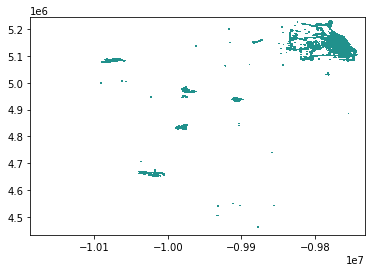

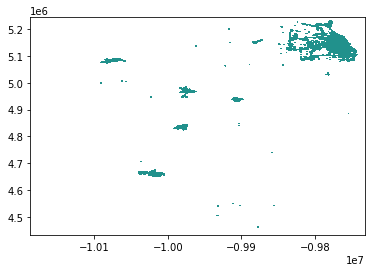

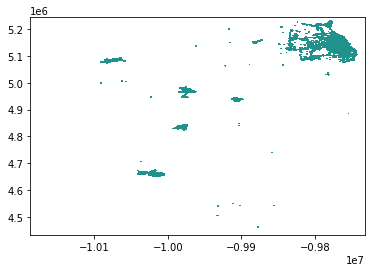

In [11]:
for layer in inputLayers:
    tiff = rasterio.open('data/' + layer['id'] + '_P' + str(layer['percentile']) + '_C' + str(layer['cutoff']) + '.tiff')
    crsEpsg = tiff.crs.to_string()

    # Set up tiff processing        
    latRange = numpy.arange(tiff.bounds.top, tiff.bounds.bottom, -tiff.res[1])
    lonRange = numpy.arange(tiff.bounds.left, tiff.bounds.right, tiff.res[0])

    combinedGeojson = {
        'crs': {'type':'name','properties':{'name': crsEpsg}},
        'type': 'FeatureCollection',
        'features': []
    }    

    figure = plt.figure().add_subplot(111)
    values =  tiff.read(1)
    contourf = figure.contourf(lonRange, latRange, values, levels = accessBins)
    contourJson = geojson.loads(geojsoncontour.contourf_to_geojson(contourf = contourf, ndigits = 3))

    for i in range(len(contourJson['features'])):
        feature = contourJson.features[i]
        minReachable = list(accessBins)[i]
        
        # Replace default properties from matplotlib contourf
        feature.properties = {
            'minReachable': minReachable,
        }
        

        # The next two steps remove shapes with no coordinates, zero-area artifacts, 
        # and self-intersections
        nextContour = shape({
            'type': 'MultiPolygon', 
            'coordinates': list(filter(
                lambda coords: (len(coords) > 0), 
                feature.geometry.coordinates))
        })
        
        nextContour = MultiPolygon(list(filter(lambda poly: (poly.area > 0), nextContour))).buffer(0)

        # countourf returns the area between the requested intervals (e.g. a bandreachable in 
        # between 15 and 30 minutes). Union this band with the previous ones to show the cumulative
        # area reachable.
        if i > 0:
            nextContour = nextContour.union(shape(isochroneJson['features'][i - 1]['geometry']))

        feature.geometry = json.loads(shapely_geojson.dumps(nextContour))
        combinedGeojson['features'].append(feature)
        
    with open('data/' + layer['id'] + '_P' + str(layer['percentile']) + '_C' + str(layer['cutoff']) + '.geojson', 'w') as f:
        json.dump(combinedGeojson, f)
    f.close()